# Exercise 6 - FIR and IIR filters

## Objectives
- To introduce Finite Impulse Response (FIR) filters
- To introduce Infinite Impulse Response (IIR) filters

In [1]:
import os
os.makedirs('results/ex6', exist_ok=True)

## Lab Exercise

The filter impulse response is the output when the input is $\delta[n]$. Recall that an impulse signal contains equal power in all frequency components, i.e. its magnitude spectrum is a constant across all frequencies (flat). Therefore, the frequency response of a filter is simply the discrete Fourier transform of the filter's impulse response.

We already have seen a simple example of Finite Impulse Response (FIR) filter in Exercise 5. In this exercise, we are going to look at Python tools for FIR filter design. We will also learn about Infinite Impulse Response (IIR) filters.

### Finite Impulse Repsonse (FIR) Filters

---
**Definition**:
    
$$\text{Finite Impulse Response (FIR) Filter: }y[n]=\sum^{M}_{k=0}b[k]x[n-k]$$

---

The $(M+1)$ coefficients of FIR filters are $b[n]$, where $n=0,\dots,M$. Consider an FIR filter whose coefficients consists of a sequence of 4 ones. 


**Question 6.1**: Describe the frequency response, $B(e^{j\Omega})$, of the filter, $b[n] = \big[1,\: 1,\: 1,\: 1\big]$, using `plot_spec` provided in the `lab_functions` file. What do you observe about the phase? You should already be familiar with this filter from Exercise 5.


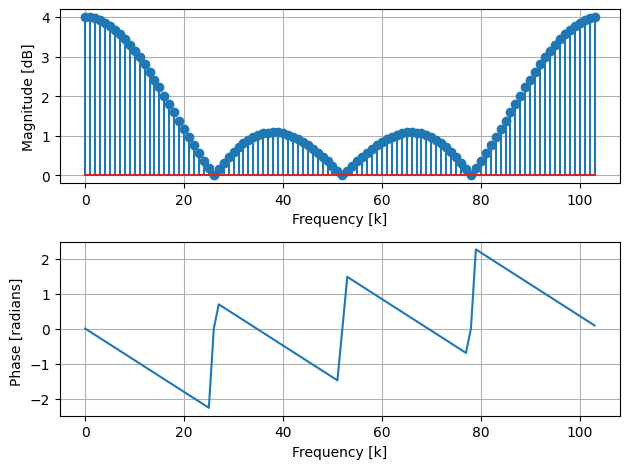

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from functions.lab_functions import plot_spec

b = np.concatenate((np.ones(4), np.zeros(100)))
B = fft(b)
plt = plot_spec(B, func='stem')
plt.show()

This filter keeps the low frequency components intact and reduces the high frequency components. It is, therefore, known as a low-pass filter.

**Question 6.2**: Suppose the input signal to the filter is $x[n]$, show that this filter produces the output $y[n] = x[n] + x[n-1]+ x[n-2] + x[n-3]$.


Now let us create a moving average filter and use it on some real-world data, namely the number of daily Coronavirus (COVID-19) cases in the UK between 2020-01-30 and 2020-06-29. Start by loading `coronavirus.mat` from the file:

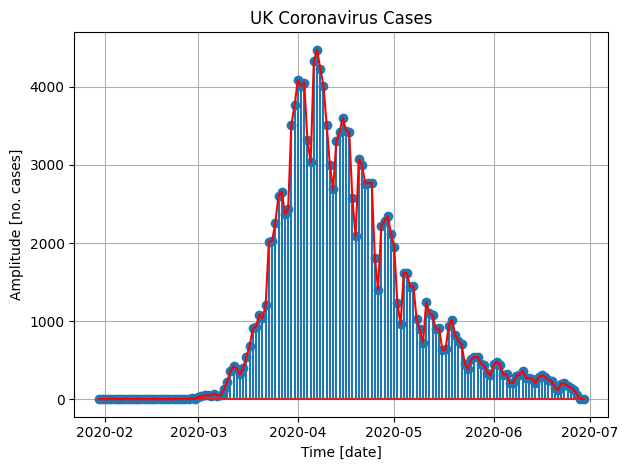

In [2]:
import datetime
import IPython.display as ipd

from functions.lab_functions import load
from functions.lab_functions import plot_signal

data = load('files/coronavirus.mat', 'data')

t = [datetime.date(2020, 1, 30) + datetime.timedelta(days=x) for x in range(len(data))]

plt = plot_signal(t, data, title='UK Coronavirus Cases', xlabel='Time [date]', ylabel='Amplitude [no. cases]', func='stem')

## Write code to implement moving average filter and compute filtered_data
filtered_data = data # modify this line for filtered data
plt.plot(t, filtered_data, color='red')
plt.show()

**Question 6.3** Implement a 4 day moving average filter (Hint: $b[n] = \frac{1}{4}\big[1,\: 1,\: 1,\: 1\big]$)  which can be done using the `np.convolve(x, b)` function to perform a convolution between the signal, $x[n]$, and $b[n]$.


**Question 6.4** Compare the waveform before and after filtering. Do you see what you would have expected? Now modify $b[n]$ to implement a 7 day moving average filter.



We can create impressive FIR filters using Python's filter designer functions.  Let us start by listening to the audio file `aircrew.wav`:

<audio controls src="files/aircrew.wav"> 
</audio>

Now run the code below that calculates these FIR coefficients using Python’s filter designer functions. It then applies a band-stop filter to the audio file `aircrew.wav`. Listen to the audio output.

0.030612244897959183


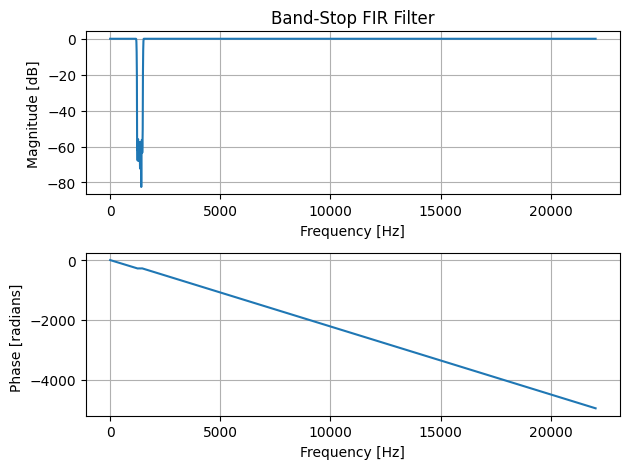

Filtered Audio Output (FIR Band-stop):


In [3]:
import soundfile as sf
from scipy import signal
from functions.lab_functions import plot_spec

x, fs = sf.read('files/aircrew.wav')       

# The Nyquist rate of the signal.
nyq_rate = fs/2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 50 Hz transition width.
width = 50.0/nyq_rate

# The desired attenuation in the stop band in dB.
ripple_db = 60

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)
print(1350/fs)
# Desired stop band, Hz
band = [1200, 1500]  

# Use firwin with a Kaiser window to create a lowpass FIR filter.
b_fir_bsf_new = signal.firwin(N, [b/nyq_rate for b in band])

w, h = signal.freqz(b_fir_bsf_new, [1], worN=2000)

f_step = w*fs/(2*np.pi)
plt = plot_spec(f_step, h, title='Band-Stop FIR Filter', dB=True)
plt.show()

y_bs = np.convolve(x, b_fir_bsf_new);

sf.write('results/ex6/aircrew_fir_bsf.wav', y_bs, fs) 
print('Filtered Audio Output (FIR Band-stop):')
ipd.Audio('results/ex6/aircrew_fir_bsf.wav')

You have probably notice that this recording also contains a lot of background noise at high frequencies. Let us now design a low-pass filter using `firwin` to create the coefficients, `b_fir_lpf`, for the low-pass filter. Listen to this output and compare with the previous version.

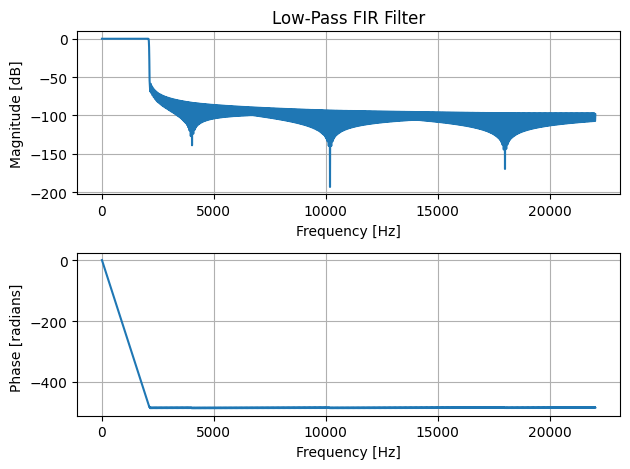

Filtered Audio Output (FIR Band-stop + Low-pass):


In [4]:
# Desired stop band, Hz
band = [2100]  

# Use firwin with a Kaiser window to create a lowpass FIR filter.
b_fir_lpf = signal.firwin(N, [b/nyq_rate for b in band])

w, h = signal.freqz(b_fir_lpf, [1], worN=2000)

f_step = w*fs/(2*np.pi)
plt = plot_spec(f_step, h, title='Low-Pass FIR Filter', dB=True)
plt.show()

y_lp = np.convolve(y_bs, b_fir_lpf);

sf.write('results/ex6/aircrew_fir_bsf_lpf.wav', y_lp, fs) 
print('Filtered Audio Output (FIR Band-stop + Low-pass):')
ipd.Audio('results/ex6/aircrew_fir_bsf_lpf.wav')

Let us compare this result with the direct-method approach used in Exercise 4. To save time, the complete code has been provided below

In [5]:
from scipy.fft import fft
from scipy.fft import ifft

x, fs = sf.read('files/aircrew.wav') 
Tsamp = 1/fs
Nsamp = len(x)
t = np.arange(0, Nsamp*Tsamp, Tsamp)

X = fft(x); 

cutoff = 2200;
band_start = 1200;
band_end = 1500;
n = round(cutoff/fs*Nsamp); # calculate the frequency index
n_start = round(band_start/fs*Nsamp); 
n_end = round(band_end/fs*Nsamp); 

X[n:-n] = 0; # low-pass
X[n_start:n_end] = 0; # band-stop (1)
X[-n_end:-n_start] = 0; # band-stop (2)

y = np.real(ifft(X));

sf.write('results/ex6/aircrew_freq_bsf_lpf.wav', y, fs) 
print('Filtered Audio Output (Using Filtering Approach From Ex. 4 - Band-stop + Low-pass):')
ipd.Audio('results/ex6/aircrew_freq_bsf_lpf.wav')

Filtered Audio Output (Using Filtering Approach From Ex. 4 - Band-stop + Low-pass):


**Question 6.5**: The performance using the direct approach from Exercise 5 is worse. Can you explain why? Can you also hear the difference between `aircrew_fir_bsf_lpf.wav` and `aircrew_freq_bsf_lpf.wav`? Hint: The low-pass filter we have just created using the direct method from Exercise 4 has the following frequency response given below.

> **GTA Tip** 
>
> You may want to listen to these audio clips with headphones to hear the difference between filtering methods.

<img src="img/ex7_1.png"/> 



### Inifite Impulse Response (IIR) Filters
In this exercise, we will explore another type of filter which has an impulse response of infinite length, the **Infinite Impulse Response (IIR)** filter. It is a recursive filter because old outputs are fed back to calculate the new output as described by the following equation:

---
**Definition**:
    
$$\text{Infinite Impulse Response (IIR) Filter: }y[n]=\sum^{M}_{k=0}b[k]x[n-k]-\sum^{N}_{k=1}a[k]y[n-k]$$

---

Python provides a function called filter to perform general FIR and IIR filtering.

```python
from scipy import signal
y = signal.filtfilt(b, a, x)
```

where `b` = $\big[b[0],\: b[1], \cdots, b[1-M]\big]$ and `a` = $\big[1,\: a[1], a[2], \cdots, a[N-1]\big]$. Note that the FIR filter above can be implemented using `filtfilt` where `a` = $\big[1\big]$.


Now let us try to filter `aircrew.wav` using IIR filters, e.g. Butterworth filters.

<audio controls src="files/aircrew.wav"> 
</audio>

In [6]:
import scipy.io
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from scipy import signal

fs = 44100
band = [1200, 1500]
N = 5

nyq = 0.5 * fs
b_iir_bsf, a_iir_bsf = signal.butter(N, [b/nyq for b in band], btype='bandstop')

fcut = 2000
N = 15

nyq = 0.5 * fs
b_iir_lpf, a_iir_lpf = signal.butter(N,  fcut/nyq, btype='low')
print(b_iir_lpf, a_iir_lpf)
# print(b_iir_bsf)

x, fsamp = sf.read('files/aircrew.wav')

y_bs = signal.filtfilt(b_iir_bsf, a_iir_bsf, x)
y_lp = signal.filtfilt(b_iir_lpf, a_iir_lpf, y_bs)

sf.write('results/ex6/aircrew_iir_bsf.wav', y_bs, fsamp)
print('Filtered Audio Output (IIR Band-stop):')
ipd.display(ipd.Audio('results/ex6/aircrew_iir_bsf.wav')) # display audio player

sf.write('results/ex6/aircrew_iir_bsf_lpf.wav', y_lp, fsamp)
print('Filtered Audio Output (IIR Band-stop + Low-pass):')
ipd.display(ipd.Audio('results/ex6/aircrew_iir_bsf_lpf.wav')) # display audio player

[5.69881594e-14 8.54822391e-13 5.98375674e-12 2.59296125e-11
 7.77888376e-11 1.71135443e-10 2.85225738e-10 3.66718806e-10
 3.66718806e-10 2.85225738e-10 1.71135443e-10 7.77888376e-11
 2.59296125e-11 5.98375674e-12 8.54822391e-13 5.69881594e-14] [ 1.00000000e+00 -1.22741999e+01  7.05165337e+01 -2.51512461e+02
  6.22768623e+02 -1.13383812e+03  1.56789271e+03 -1.67669527e+03
  1.39794023e+03 -9.08628315e+02  4.56620960e+02 -1.74220004e+02
  4.88495023e+01 -9.50196551e+00  1.14645690e+00 -6.46773006e-02]
Filtered Audio Output (IIR Band-stop):


Filtered Audio Output (IIR Band-stop + Low-pass):


**Question 6.6** Compare the frequency response of the FIR and IIR low pass filters you have just created. Does the frequency response make sense based on what you observe (listen) in the filtered signal?

A simple way to compute and plot the frequency response of the IIR filter you have just created is

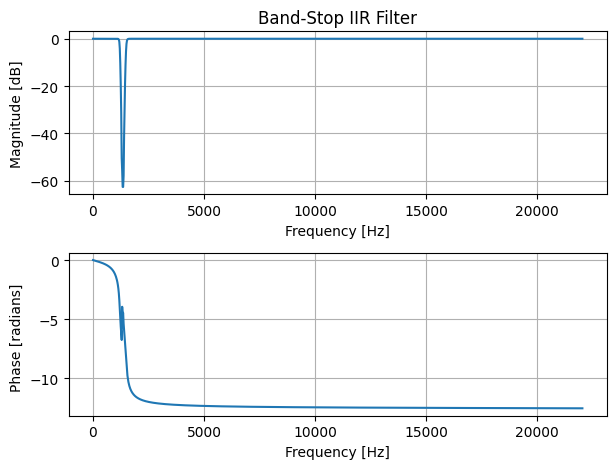

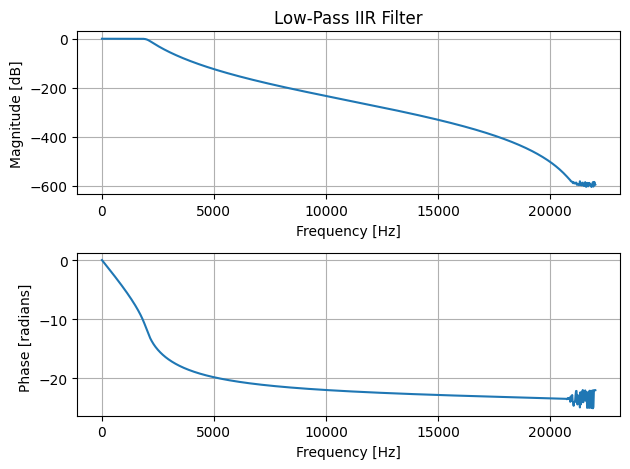

In [7]:
from functions.lab_functions import plot_spec

w, h = signal.freqz(b_iir_bsf, a_iir_bsf, worN=1024)
f_step = w*fs/(2*np.pi)
plt = plot_spec(f_step, h, title='Band-Stop IIR Filter', dB=True)
plt.show()

w, h = signal.freqz(b_iir_lpf, a_iir_lpf, worN=1024)
f_step = w*fs/(2*np.pi)
plt = plot_spec(f_step, h, title='Low-Pass IIR Filter', dB=True)
plt.show()

**Question 6.7** Derive the impulse response of: $y[n] = 0.5 x[n] + 0.5 y[n-1]$?



**Question 6.8** Why does an IIR filter have to be implemented recursively (i.e. does it absolutely need to use past output values)?



**Question 6.9** Compare the advantages and disadvantages of FIR and IIR filters (Hint: look at the number of coefficients required to implement both types of filters.)